You'll need TensorFlow, TFLite Model Maker, and some modules for audio manipulation, playback, and visualizations.

In [ ]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

In [1]:
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

2025-08-21 17:19:08.156417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-21 17:19:08.156440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/julius/miniconda3/envs/atml/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/julius/miniconda3/envs/atml/lib/python3.9/site-packages/tensorflow_

TensorFlow Version: 2.8.4
Model Maker Version: 0.4.3


## Prepare the dataset

In [2]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

### Generate a background noise dataset

Whether you're using the default speech dataset or a custom dataset, you should have a good set of background noises so your model can distinguish speech from other noises (including silence). 

Because the following background samples are provided in WAV files that are a minute long or longer, we need to split them up into smaller one-second samples so we can reserve some for our test dataset. We'll also combine a couple different sample sources to build a comprehensive set of background noises and silence:

In [24]:
tf.keras.utils.get_file('speech_commands_v0.01.tar.gz',
                        'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz',
                        cache_dir='./',
                        cache_subdir='dataset-speech',
                        extract=True)
tf.keras.utils.get_file('background_audio.zip',
                        'https://storage.googleapis.com/download.tensorflow.org/models/tflite/sound_classification/background_audio.zip',
                        cache_dir='./',
                        cache_subdir='dataset-background',
                        extract=True)


1081344/1072437 [==============================] - 1s 0us/step


'./dataset-background/background_audio.zip'

In [25]:
# Create a list of all the background wav files

files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
files = files + glob.glob(os.path.join('./dataset-background', '*.wav'))

background_dir = './background'
os.makedirs(background_dir, exist_ok=True)

# Loop through all files and split each into several one-second wav files
for file in files:
  filename = os.path.basename(os.path.normpath(file))
  print('Splitting', filename)
  name = os.path.splitext(filename)[0]
  rate = librosa.get_samplerate(file)
  length = round(librosa.get_duration(filename=file))
  for i in range(length - 1):
    start = i * rate
    stop = (i * rate) + rate
    data, _ = sf.read(file, start=start, stop=stop)
    sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)

Splitting exercise_bike.wav
Splitting doing_the_dishes.wav
Splitting white_noise.wav
Splitting dude_miaowing.wav
Splitting running_tap.wav
Splitting pink_noise.wav
Splitting silence.wav
Splitting throat_clearing.wav


In [26]:
use_custom_dataset = False
if not use_custom_dataset:
  commands = [ "up", "down", "left", "right", "go", "stop", "on", "off", "background", "cat", "dog", "down", "marvin", "seven", "sheila", "six", "stop", "three", "wow", "yes", "zero"]
  dataset_dir = './dataset-speech'
  test_dir = './dataset-test'

  # Move the processed background samples
  shutil.move(background_dir, os.path.join(dataset_dir, 'background'))   

  # Delete all directories that are not in our commands list
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    name = os.path.basename(os.path.normpath(dir))
    if name not in commands:
      shutil.rmtree(dir)

  # Count is per class
  sample_count = 99
  test_data_ratio = 0.2
  test_count = round(sample_count * test_data_ratio)

  # Loop through child directories (each class of wav files)
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[sample_count:sample_count + test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    # Delete remaining samples
    for file in files[sample_count + test_count:]:
      os.remove(file)

In [27]:
import os
import shutil

# Paths
source_root = 'dataset-speech'
destination_folder = 'data/background'

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Loop through each subfolder in source_root
for subfolder in os.listdir(source_root):
    subfolder_path = os.path.join(source_root, subfolder)

    # Ensure it's a directory
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)

            # Only move files (not subdirectories)
            if os.path.isfile(file_path):
                dest_path = os.path.join(destination_folder, filename)

                # Handle filename collisions (optional)
                if os.path.exists(dest_path):
                    base, ext = os.path.splitext(filename)
                    counter = 1
                    while os.path.exists(dest_path):
                        new_filename = f"{base}_{counter}{ext}"
                        dest_path = os.path.join(destination_folder, new_filename)
                        counter += 1

                shutil.move(file_path, dest_path)

print("All files moved to data/background/")


All files moved to data/background/


### Prepare a custom dataset

If you want to train the model with our own speech dataset, you need to upload your samples as WAV files in a ZIP ([as described above](#scrollTo=cBsSAeYLkc1Z)) and modify the following variables to specify your dataset:

In [28]:
use_custom_dataset = True
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  #!unzip YOUR-FILENAME.zip
  # Specify the unzipped path to your custom dataset
  # (this path contains all the subfolders with classification names):
  dataset_dir = './data'

After changing the filename and path name above, you're ready to train the model with your custom dataset. In the Colab toolbar, select **Runtime > Run all** to run the whole notebook.

The following code integrates our new background noise samples into your dataset and then separates a portion of all samples to create a test set.

In [18]:
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [19]:
background_dir = './data/background'
test_dir = './dataset-test'
sample_dir = './dataset-test'

In [29]:
if use_custom_dataset:
  # Move background samples into custom dataset
  move_background_dataset(dataset_dir)

  # Now we separate some of the files that we'll use for testing:
  test_dir = './dataset-test'
  test_data_ratio = 0.2
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    test_count = round(len(files) * test_data_ratio)
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[:test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    print('Moved', test_count, 'images from', class_dir)

Moved 376 images from background
Moved 20 images from training


In [39]:
import os
import shutil

# Base directory
root_dir = 'dataset-test'

# Folders to keep untouched
keep_folders = {'training', 'background'}

# Path to the background folder
background_folder = os.path.join(root_dir, 'background')

# Loop through all items in the root directory
for subfolder in os.listdir(root_dir):
    subfolder_path = os.path.join(root_dir, subfolder)

    # Skip folders we want to keep
    if subfolder in keep_folders or not os.path.isdir(subfolder_path):
        continue

    # Move all files from this subfolder to background
    for filename in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, filename)

        if os.path.isfile(file_path):
            dest_path = os.path.join(background_folder, filename)

            # Avoid filename collisions
            if os.path.exists(dest_path):
                base, ext = os.path.splitext(filename)
                counter = 1
                while os.path.exists(dest_path):
                    new_filename = f"{base}_{counter}{ext}"
                    dest_path = os.path.join(background_folder, new_filename)
                    counter += 1

            shutil.move(file_path, dest_path)

    # Remove the empty folder
    os.rmdir(subfolder_path)

print("Done: all other subfolders cleaned up, files moved to 'background'.")


Done: all other subfolders cleaned up, files moved to 'background'.


### Play a sample

To be sure the dataset looks correct, let's play at a random sample from the test set:

In [30]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: stop
File: /home/julius/Documents/ml_summerschool/dataset-test/stop/afd53389_nohash_0.wav
Sample rate: 16000
Sample length: 16000


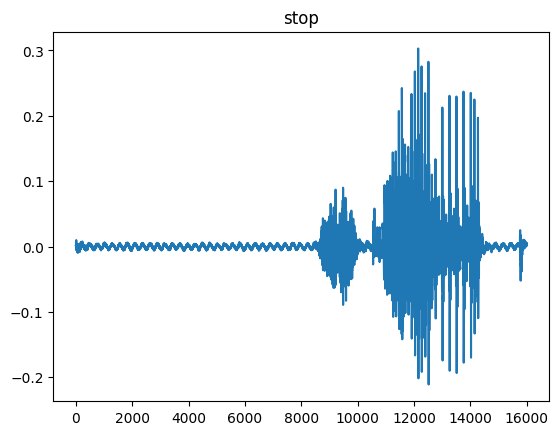

In [33]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

## Define the model


When using Model Maker to retrain any model, you have to start by defining a model spec. The spec defines the base model from which your new model will extract feature embeddings to begin learning new classes. The spec for this speech recognizer is based on the pre-trained [BrowserFft model from TFJS](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer).

The model expects input as an audio sample that's 44.1 kHz, and just under a second long: the exact sample length must be 44034 frames.

You don't need to do any resampling with your training dataset. Model Maker takes care of that for you. But when you later run inference, you must be sure that your input matches that expected format.

All you need to do here is instantiate the [`BrowserFftSpec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/BrowserFftSpec):


In [34]:
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in /tmp/tmpguc66dro
32768/18467 [=====================================================] - 0s 1us/step


2025-08-21 17:36:21.205512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/julius/miniconda3/envs/atml/lib/python3.9/site-packages/cv2/../../lib64:
2025-08-21 17:36:21.205529: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-21 17:36:21.205541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kubuntu): /proc/driver/nvidia/version does not exist
2025-08-21 17:36:21.205710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16384/203 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Load your dataset 

Now you need to load your dataset according to the model specifications. Model Maker includes the [`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/DataLoader) API, which will load your dataset from a folder and ensure it's in the expected format for the model spec.

We already reserved some test files by moving them to a separate directory, which makes it easier to run inference with them later. Now we'll create a `DataLoader` for each split: the training set, the validation set, and the test set.

#### Load a custom dataset

**Note:** Setting `cache=True` is important to make training faster (especially when the dataset must be re-sampled) but it will also require more RAM to hold the data. If you use a very large custom dataset, caching might exceed your RAM capacity.

In [40]:
if use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)


## Train the model


Now we'll use the Model Maker [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) function to create a model based on our model spec and training dataset, and begin training.

If you're using a custom dataset, you might want to change the batch size as appropriate for the number of samples in your train set.

**Note:** The first epoch takes longer because it must create the cache. 

In [41]:
# If your dataset has fewer than 100 samples per class,
# you might want to try a smaller batch size
batch_size = 16
epochs = 64
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

## Review the model performance

Even if the accuracy/loss looks good from the training output above, it's important to also run the model using test data that the model has not seen yet, which is what the `evaluate()` method does here:

In [42]:
model.evaluate(test_data)

23/23 [==============================] - 9s 375ms/step - loss: 0.0203 - acc: 0.9930


[0.020274130627512932, 0.9930264949798584]

### View the confusion matrix

When training a classification model such as this one, it's also useful to inspect the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed visual representation of how well your classifier performs for each classification in your test data.

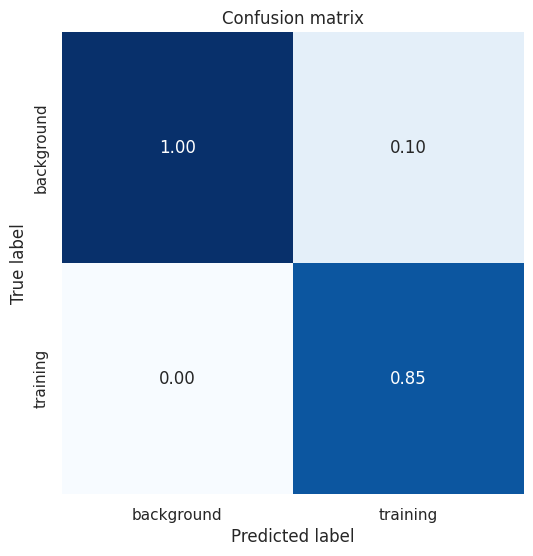

In [43]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

## Export the model

The last step is exporting your model into the TensorFlow Lite format for execution on mobile/embedded devices and into the [SavedModel format](https://www.tensorflow.org/guide/saved_model) for execution elsewhere.

When exporting a `.tflite` file from Model Maker, it includes [model metadata](https://www.tensorflow.org/lite/inference_with_metadata/overview) that describes various details that can later help during inference. It even includes a copy of the classification labels file, so you don't need to a separate `labels.txt` file. (In the next section, we show how to use this metadata to run an inference.)

In [44]:
TFLITE_FILENAME = 'browserfft-speech.tflite'
SAVE_PATH = './models'

In [45]:
print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ./models


2025-08-21 17:45:31.525010: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpulp05j4h/assets


2025-08-21 17:45:32.546146: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-08-21 17:45:32.546302: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-08-21 17:45:32.561559: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 225 nodes (167), 367 edges (297), time = 4.149ms.
  function_optimizer: Graph size after: 225 nodes (0), 367 edges (0), time = 2.029ms.
Optimization results for grappler item: __inference_Assert_AssertGuard_true_663_104
  function_optimizer: function_optimizer did nothing. time = 0.003ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
Optimization results for grappler item: __inference_Assert_AssertGuard_false_96_180
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did not

INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Saving labels in ./models/labels.txt


INFO:tensorflow:Saving labels in ./models/labels.txt


## Run inference with TF Lite model

Now your TFLite model can be deployed and run using any of the supported [inferencing libraries](https://www.tensorflow.org/lite/guide/inference) or with the new [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier). The following code shows how you can run inference with the `.tflite` model in Python.

In [ ]:
# This library provides the TFLite metadata API
! pip install -q tflite_support

In [46]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

To observe how well the model performs with real samples, run the following code block over and over. Each time, it will fetch a new test sample and run inference with it, and you can listen to the audio sample below.

---prediction---
Class: background
Score: 1.0
----truth----
Class: background
File: /home/julius/Documents/ml_summerschool/dataset-test/background/36050ef3_nohash_1_1.wav
Sample rate: 16000
Sample length: 16000


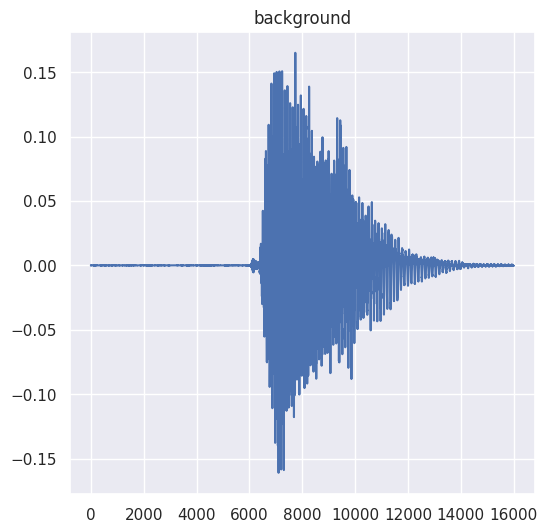

In [53]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(random_audio)

In [54]:
def generate_header_file(tflite_model_path, header_path):
    """Generate a C header file from a TFLite model."""
    # Read the TFLite model binary
    with open(tflite_model_path, 'rb') as f:
        model_bytes = f.read()
    
    # Convert bytes to hex representation
    hex_lines = []
    for i, byte in enumerate(model_bytes):
        if i % 12 == 0:
            hex_lines.append('\n  ')
        hex_lines.append(f'0x{byte:02x},')
    
    # Write the header file
    with open(header_path, 'w') as f:
        f.write('const unsigned char model[] = {')
        f.write(''.join(hex_lines))
        f.write('\n};\n')
        f.write(f'const unsigned int model_len = {len(model_bytes)};\n')

In [55]:
print("\nConverting model to TFLite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
open("gesture_model.tflite", "wb").write(tflite_model)
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

# Generate header file
os.makedirs('./output', exist_ok=True)
header_path = './output/model.h'
generate_header_file('gesture_model.tflite', header_path)

model_h_size = os.path.getsize(header_path)
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nModel has been converted to model.h in the output directory.")



Converting model to TFLite format...


AttributeError: 'AudioClassifier' object has no attribute 'call'